### Title: Predicting Cleveland Heart Disease

#### Group 41 - DSCI100 Project Report

##### **Introduction**

Scientists aim to predict the presence of heart disease based on various medical attributes. This helps patients with heart disease receive proper treatment, and minimizes the costly resources used on healthy patients. Thus, this project investigates the question: "can age, serum cholesterol, and thalach (maximum heart rate achieved) measurements predict the presence of heart disease for males?" We will use the Heart Disease dataset, which contains 14 medical attributes for 303 individuals in Cleveland. The num column indicates presence (categories 1-4) or absence (category 0) of heart disease, with 1-4 referring to different diseases. This project will combine categories 1-4 to focus on presence vs absence, as some diseases are extremely rare (leading to very unbalanced data). Once heart disease is detected, patients can receive further treatment to determine their specific disease.

##### **Methods & Results**

We begin by downloading and tidying the Heart Disease dataset. Column names are assigned for readability, and factor columns are used for categorical variables. For clarity, Table 1 shows the first 6 rows of the 303 row tibble.

In [14]:
library(tidyverse)
library(repr)
library(tidymodels) 
url<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(url,"cleveland_heart_disease.csv")
cleveland_data<-read_csv("cleveland_heart_disease.csv",col_names=FALSE)|>
rename(age=X1,sex=X2,cp=X3,trestbps=X4,chol=X5,fbs=X6,restecg=X7,thalach=X8,exang=X9,oldpeak=X10,slope=X11,ca=X12,thal=X13,num=X14)|>
    mutate(across(sex:cp,as_factor))|>
    mutate(across(fbs:restecg,as_factor))|>
    mutate(exang=as_factor(exang),slope=as_factor(slope),thal=as_factor(thal),num=as_factor(num))
head(cleveland_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


The sex column contains 1 (male) or 0 (female). Data will be filtered for males to focus on a more specific demographic, reducing the variability of measurements due to factors besides heart disease. Below, we combine categories 1-4 in the num column to represent "presence" of heart disease, and split the dataset (75% into the training set, 25% into the testing set) to do preliminary exploration. The selected predictor columns contain no missing values.

In [29]:
filtered_data<-cleveland_data|>
    filter(sex==1)|>
    select(age,chol,thalach,num)|>
    mutate(num=fct_recode(num,"Present"="1","Present"="2","Present"="3","Present"="4","Absent"="0"))
head(filtered_data)

set.seed(9)
data_split<-initial_split(filtered_data,prop=0.75,strata=num)
data_train<-training(data_split)
data_test<-testing(data_split)

distribution_num<-data_train|>
    group_by(num)|>
    summarize(count=n())
distribution_num

mean_predictors<-data_train|>
    group_by(num)|>
    summarize(avg_age=mean(age),avg_chol=mean(chol),avg_thalach=mean(thalach))
mean_predictors

age,chol,thalach,num
<dbl>,<dbl>,<dbl>,<fct>
63,233,150,Absent
67,286,108,Present
67,229,129,Present
37,250,187,Absent
56,236,178,Absent
63,254,147,Present


num,count
<fct>,<int>
Absent,69
Present,85


num,avg_age,avg_chol,avg_thalach
<fct>,<dbl>,<dbl>,<dbl>
Absent,51.01449,224.7536,161.3188
Present,56.62353,244.5294,136.9647


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


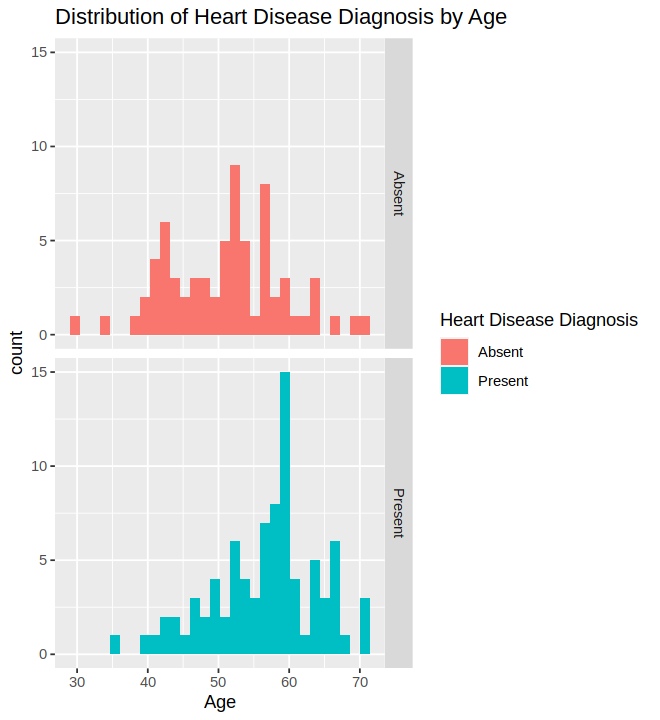

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


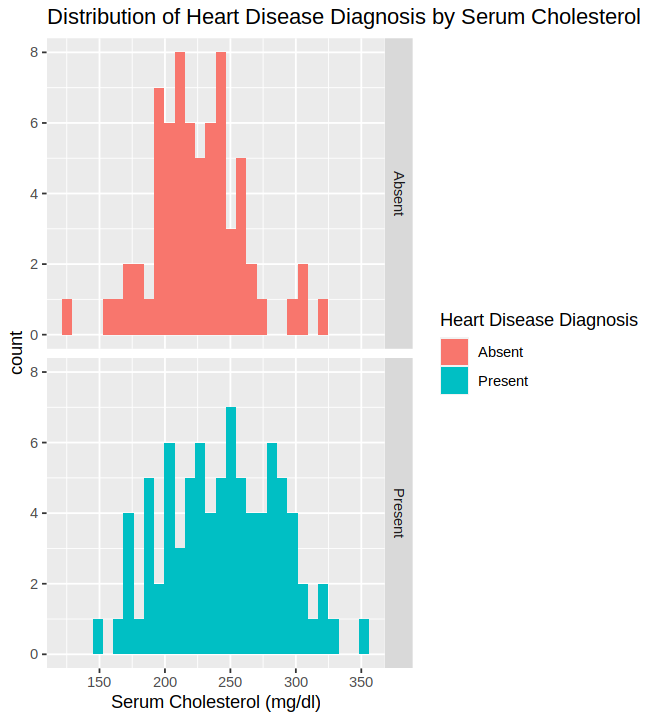

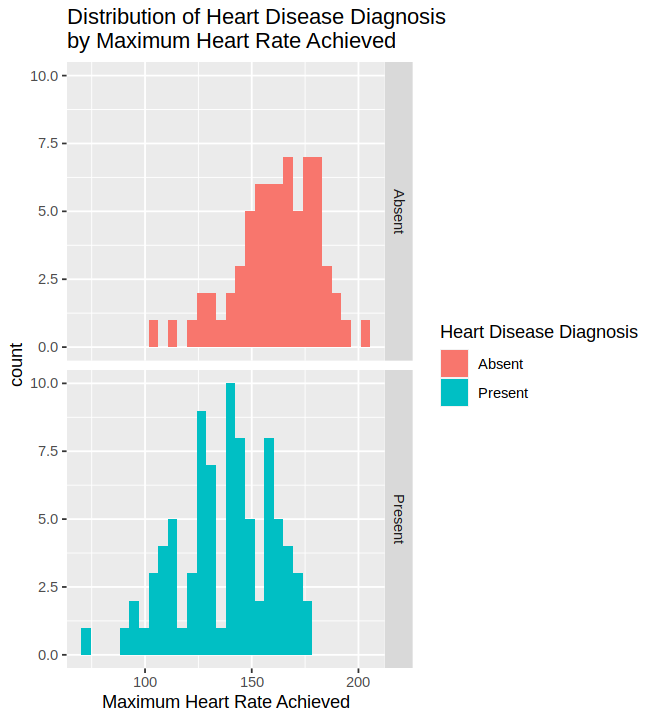

In [30]:
options(repr.plot.width = 5.5, repr.plot.height = 6)
graph_age<-data_train|>
    ggplot(aes(x=age,fill=num))+
        geom_histogram()+
    facet_grid(rows=vars(num))+
    labs(x="Age",fill="Heart Disease Diagnosis")+
    ggtitle("Distribution of Heart Disease Diagnosis by Age")
graph_age

graph_chol<-data_train|>
    ggplot(aes(x=chol,fill=num))+
        geom_histogram()+
    facet_grid(rows=vars(num))+
     labs(x="Serum Cholesterol (mg/dl)",fill="Heart Disease Diagnosis")+
    ggtitle("Distribution of Heart Disease Diagnosis by Serum Cholesterol")
graph_chol

graph_thalach<-data_train|>
    ggplot(aes(x=thalach,fill=num))+
        geom_histogram()+
    facet_grid(rows=vars(num))+
     labs(x="Maximum Heart Rate Achieved",fill="Heart Disease Diagnosis")+
    ggtitle("Distribution of Heart Disease Diagnosis \nby Maximum Heart Rate Achieved")
graph_thalach

Methods

Our data analysis will use the KNN classification method. The predicted attribute will be whether heart disease is "present" or "absent" in the patient. The predictors will include age, chol (serum cholesterol (mg/dl)), and thalach. They're most directly associated with heart disease, and are numerical values (not categorical) that can be used with KNN. This will allow us to take a new observation, plot it against the training data, and predict the type of heart disease depending on the mode classification of the K-nearest neighbors. One way we’ll visualize the results is using a scatter plot with two predictors on the x and y axes, and points coloured by presence or absence of heart disease.

Expected outcomes and significance

Our model aims to predict whether an individual has heart disease using age, cholesterol, and thalach measurements. Considering the distributions, we expect older individuals (around high 50s) with higher cholesterol (around 250 mg/dl) and lower thalach (high 130s) to have heart disease, and younger individuals with lower cholesterol and higher thalach to be absent of heart disease. These findings give doctors more insight and evidence into trends for heart diseases, which reduces misdiagnoses. This may also decrease the time required for diagnoses, minimizing opportunities for the disease to worsen. This allows patients with heart diseases to receive proper treatment in a timely manner, lengthening their lives. It also reduces the resources which are unnecessarily used on healthy patients. Findings could lead to further questions, including “could high cholesterol and low thalach be indications of other medical problems as well?” Followup investigations could also include whether treatments like lowering cholesterol or raising thalach may help reduce risks of heart disease.

In [31]:
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [32]:
library(themis) 

In [33]:
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [34]:
library(kknn)

num,n
<fct>,<int>
Absent,114
Present,114


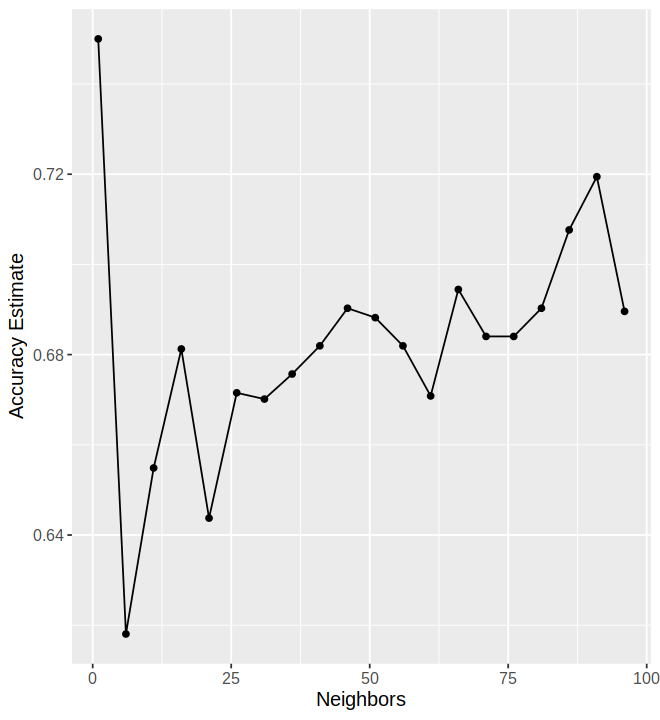

In [35]:
#Balancing the Data 
cleveland_recipe <- recipe(num ~., data = filtered_data) |> 
step_upsample(num, over_ratio = 1, skip = FALSE) |> 
prep() 

upsampled_cleveland <- bake(cleveland_recipe, filtered_data)
upsampled_cleveland |> 
group_by(num) |> 
summarize(n = n()) 

#Splitting training and testing data 
set.seed(9)
cleveland_split<-initial_split(upsampled_cleveland,prop=0.75,strata=num)
cleveland_train<-training(cleveland_split)
cleveland_test<-testing(cleveland_split)

#Standardizing the data 
cleveland_recipe_scale <- recipe(num ~., data = cleveland_train)|> 
step_scale(all_predictors()) |> 
step_center(all_predictors()) 

#Nearest Neighbors 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
set_engine("kknn") |> 
set_mode("classification") 

#Cross Validation (what number of folds should we do here?) 
cleveland_vfold <- vfold_cv(cleveland_train, v = 10, strata = num) 

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5)) 

knn_results <- workflow() |> 
add_recipe(cleveland_recipe_scale) |> 
add_model(knn_spec) |> 
tune_grid(resamples = cleveland_vfold, grid = k_vals) |> 
collect_metrics() 

accuracies <- knn_results |> 
filter(.metric == "accuracy") 

#Plot for choosing K 
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
geom_point() + 
geom_line() + 
labs(x = "Neighbors", y = "Accuracy Estimate") + 
theme(text = element_text(size = 12)) 

accuracy_vs_k

In [36]:
# Make K = 61? Unsure why there is a huge peak at K=1 

In [37]:
new_spec<-nearest_neighbor(weight_func = "rectangular", neighbors = 61) |> 
set_engine("kknn") |> 
set_mode("classification")

new_results <- workflow() |> 
add_recipe(cleveland_recipe_scale) |> 
add_model(new_spec) |> 
fit(data=cleveland_train)

cleveland_test_predictions<-predict(new_results,cleveland_test)|>
    bind_cols(cleveland_test)
cleveland_test_predictions

cleveland_test_predictions|>metrics(truth=num,estimate=.pred_class)|>
    filter(.metric=="accuracy")

.pred_class,age,chol,thalach,num
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Absent,57,126,173,Absent
Absent,39,321,182,Absent
Absent,44,226,169,Absent
Absent,56,240,169,Absent
Absent,57,168,174,Absent
Absent,51,222,143,Absent
Absent,46,197,156,Absent
Absent,42,244,178,Absent
Absent,59,212,157,Absent


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.637931


In [38]:
heart_subset <- cleveland_data |> 
  select(num,age,trestbps,chol,thalach,oldpeak)

names <- colnames(heart_subset |> select(-num))
head(heart_subset)

example_formula <- paste("num", "~", paste(names, collapse="+"))
example_formula

num,age,trestbps,chol,thalach,oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,63,145,233,150,2.3
2,67,160,286,108,1.5
1,67,120,229,129,2.6
0,37,130,250,187,3.5
0,41,130,204,172,1.4
0,56,120,236,178,0.8


[1] "num ~ age+trestbps+chol+thalach+oldpeak"

In [39]:
# create an empty tibble to store the results
new_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
new_knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
new_heart_vfold <- vfold_cv(heart_subset, v = 5, strata = num)

# store the total number of predictors
n_total <- length(names)
n_1 <- c()

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("num", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        new_heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(cleveland_recipe_scale) |>
          add_model(new_knn_spec) |>
          tune_grid(resamples = new_heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    new_accuracies <- new_accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
new_accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,num ~ trestbps,0.5245472
2,num ~ trestbps+age,0.5144907
3,num ~ trestbps+age+chol,0.5144907
4,num ~ trestbps+age+chol+thalach,0.5245472
5,num ~ trestbps+age+chol+thalach+oldpeak,0.5144907
